# Damage-plasticity model with generic time stepping
This notebook is a work in progress on an abstract and general implementation of time integration algorithm for general damage-plasticity modes. It serves for the development of a package that can be configured by specifying the ingredients of thermodynamically based model

 - Vector of state variables $\boldsymbol{\mathcal{E}}$
 - Vector of thermodynamic streses $\boldsymbol{\mathcal{S}}$
 - Helmholtz free energy $\psi(\boldsymbol{\mathcal{E}})$
 - Threshold on thermodynamical forces  $f(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$ / Yield condition
 - Flow potential $\varphi(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$

as symbolic equations using the sympy package. The time-stepping algorithm gets generated automatically within the thermodynamically framework. The derived  evolution equations and return-mapping to the yield surface is performed using Newton-Raphson scheme.  

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

**Code generation** The derivation is adopted for the purpose of code generation both in Python and C utilizing the `codegen` package provided in `sympy`. The expressions that are part of the time stepping algorithm are transformed to an executable code directly at the place where they are derived. At the end of the notebook the C code can be exported to external files and applied in external tools. 

In [2]:
from sympy.utilities.codegen import codegen
import re
def _print_Symbol(self, expr):
    CodePrinter = sp.printing.codeprinter.CodePrinter
    name = super(CodePrinter, self)._print_Symbol(expr)
    return re.sub(r'[\\\{\}]', '', name)
sp.printing.codeprinter.CodePrinter._print_Symbol = _print_Symbol

## TODO
 - The current implementation uses the threshold function linearized along $\lambda$ to represent the consistency condition. As the next step include the fully linearized set of evolution equations and threshold functions. This might be important for SLIDE 3.x, 2D and 3D problems (von Mises, Drucker-Prager). In the current one-dimensional problem it probably has no effect - this feature will be included in SLIDE-core notebook which should be able to generate all the other problems by configuring the thermodynamic inputs symbolically.  
 - Put the derived get_methods into a class and let the predictor-corrector implementation just access them. With this, the iteration scheme becomes completely generic. Any kind of model can be implemented then using the thermodynamic framework.

&nbsp;<font color='blue'>
**Naming conventions:**
 - Variables with trailing underscore (e.g. `f_`, or `Sig_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `Sig` have no underscore at the end and have an the name which is close to the mathematical symbol
 - Mathematical symbols defined as string in `sp.symbols(r'\tau^{\pi}')` use `latex` syntax to introduce Greek symbols, super and subindexes. This makes the pretty printing of expression possible.
 - In an implemented algorithm at the end of the notebook, the Python variables containing the numerical values of the material parameters $E_b$, $\tau_\mathrm{Y}$, etc. are denoted with a leading underscore `_E_b` and `_tau_Y` to avoid name collisions within the notebook
</font>

## Material parameters

In [3]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)

In [4]:
py_vars = ('E_b', 'gamma', 'K', 'S', 'r', 'c', 'tau_bar')
map_py2sp = {py_var : globals()[py_var] for py_var in py_vars}
sp_vars = tuple(map_py2sp[py_var] for py_var in py_vars)

## State variables

In [5]:
s = sp.Symbol('s', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)

In [6]:
Eps = sp.Matrix([s_pi, z, alpha, omega])
Eps.T

## Helmholtz free energy

The starting point in the thermodynamical representation of a process is a potential function of time dependent state variables. To describe the evolution of the state correctly describing the energy dissipation of the system the gradient of the potential function with respect to the state variables provides the generalized forces. The forces are constrained to characterize specific material properties, e.g. strength, hardening.

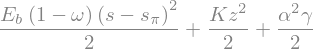

In [7]:
rho_psi_ = sp.Rational(1,2)* ( 
    (1-omega)*E_b*(s-s_pi)**2 + K * z**2 + gamma * alpha**2
)
rho_psi_

## Thermodynamic forces

In [8]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)

In [9]:
Sig = sp.Matrix([tau_pi, Z, X, Y])
Sig.T

The introduce the thermodynamic forces we have to differentiate Hemholtz free energy
with respect to the kinematic state variables
\begin{align}
\frac{\partial \rho \psi }{\partial \boldsymbol{\mathcal{E}}}
\end{align}

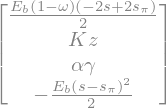

In [10]:
d_rho_psi_ = sp.Matrix([rho_psi_.diff(eps) for eps in Eps])
d_rho_psi_

To obtain consistent signs of the Helmholtz derivatives we define a sign switch operator so that all generalized forces are defined as positive for the respective conjugate state variable $\boldsymbol{\Upsilon}$. 

In [11]:
Sig_signs = sp.diag(-1,1,1,-1)

The constitutive laws between generalized force and kinematic variables then read
\begin{align}
\boldsymbol{\mathcal{S}} = \boldsymbol{\Upsilon}\frac{\rho \psi}{\partial\boldsymbol{\mathcal{E}}} 
\end{align}

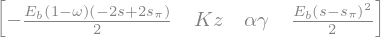

In [12]:
Sig_ = Sig_signs * d_rho_psi_
Sig_.T

**Executable code for** $\boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [13]:
get_Sig = sp.lambdify( 
    (s, Eps) + sp_vars, Sig_.T, 'numpy'
)
get_Sig_C = codegen(('Sig', Sig_), 'C89', 'SLIDE1_3')

To derive the time stepping procedure we will need also the matrix of derivatives of the generalized stresses $\boldsymbol{\mathcal{S}}$ with respect to the kinematic variables $\boldsymbol{\mathcal{E}}$ 
\begin{align}
\frac{\partial \boldsymbol{S}}{\partial \boldsymbol{E}}
\end{align}

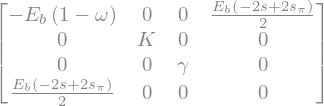

In [14]:
dSig_dEps_ = sp.Matrix([ 
    Sig_.T.diff(eps) for eps in Eps 
] ).T
dSig_dEps_

**Executable Python code generation** $\displaystyle \frac{\partial }{\partial \boldsymbol{\mathcal{E}}}  \boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [15]:
get_dSig_dEps = sp.lambdify(
    (s, Eps) + sp_vars, dSig_dEps_, 'numpy'
)
get_dSig_dEps_C = codegen(('dSig_dEps', dSig_dEps_), 'C89', 'SLIDE1_3')

## Threshold function

To keep the framework general for different stress norms and hardening definitions let us first introduce a general function for effective stress. Note that the observable stress $\tau$ is identical with the plastic stress $\tau_\pi$ due to the performed sign switch in the definition of the thermodynamic forces.

In [16]:
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega)
Q = sp.Function('Q')(tau_eff,X)
tau_eff

The stress norm is defined using the stress offset $X$, i.e. the kinematic hardening stress representing the shift of the origin of the yield locus.  

In [17]:
norm_Q = sp.sqrt(Q*Q)

General form of the yield condition then reads

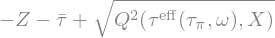

In [18]:
f = norm_Q - Z - tau_bar
f

Let us now introduce the back stress $X$ by defining the substitution for $Q = \tau^\mathrm{eff} - X$

In [19]:
subs_Q = {Q: tau_eff - X}
subs_Q

Further substitution rule introduces the effective stress as a function of damage as

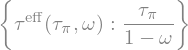

In [20]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega)}
subs_tau_eff

After substitutions the yield function reads

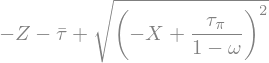

In [21]:
f_ = f.subs(subs_Q).subs(subs_tau_eff)
f_

**Executable code generation** $f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$

Note that this is a function of both the forces and kinematic state variables

In [38]:
get_f = sp.lambdify(
    (Eps, Sig) + sp_vars, f_, 'numpy'
)
get_f_C = codegen(('f', f_), 'C89', 'SLIDE1_3')

The derivative of $f$ required for time-stepping $\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}$ is obtained as

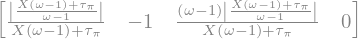

In [39]:
df_dSig_ = f_.diff(Sig)
sp.simplify(df_dSig_).T

**Executable code generation** $\displaystyle \frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [40]:
get_df_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars, df_dSig_, 'numpy'
)
get_df_dSig_C = codegen(('df_dSig', df_dSig_), 'C89', 'SLIDE1_3')

Due to the direct dependency of $f$ on $\boldsymbol{\mathcal{E}}$ also the term $\displaystyle\frac{\partial^\mathrm{dir} f}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}}$ must be provided for numerical evaluation of derivatives

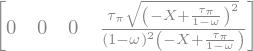

In [41]:
ddf_dEps_ = f_.diff(Eps)
ddf_dEps_.T

**Executable Python code generation** $\displaystyle\frac{\partial }{\partial \boldsymbol{\mathcal{E}}} f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [42]:
get_ddf_dEps = sp.lambdify(
    (Eps, Sig) + sp_vars, ddf_dEps_, 'numpy'
)
get_ddf_dEps_C = codegen(('df_dEps', ddf_dEps_), 'C89', 'SLIDE1_3')

## Flow potential
For non-associative flow rule let us define an extension to be added to the threshold function 

In [43]:
phi_ext = S* (1-omega)**c / (r+1) * (Y/S)**(r+1) 

The flow potential $\varphi(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$ reads

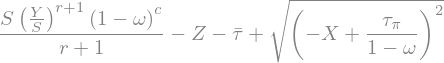

In [44]:
phi_ = f_ + phi_ext
phi_

and the corresponding directions of flow given as a product of the sign operator $\Upsilon$ and of the derivatives with respect to state variables 
$\boldsymbol{\Upsilon} \, \partial_{\boldsymbol{\mathcal{S}}} \varphi$
This renders following flow direction vector
\begin{align}
\boldsymbol{\Phi} = - \Upsilon \frac{\partial \varphi}{\partial \boldsymbol{\mathcal{S}}} 
\end{align}

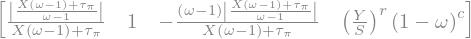

In [45]:
Phi_ = -Sig_signs * phi_.diff(Sig)
sp.simplify(Phi_.T)

**Executable code generation** $\boldsymbol{\Phi}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [46]:
get_Phi = sp.lambdify(
    (Eps, Sig) + sp_vars, Phi_, 'numpy'
)
get_Phi_C = codegen(('dPhi', Phi_), 'C89', 'SLIDE1_3')

# Time integration scheme

## Discrete yield condition
In a continuous case we consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
\dot{f}(\boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}(\lambda)}), \boldsymbol{\mathcal{E}(\lambda)} ) &= 0 \end{align}
In discrete case, we relax this requirement. Indeed, by taking $f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $ as a first trial value we can obtain positive values.

&nbsp;<font color="green">
**We allow for "trial" states which lie beyond the admissible domain $f \le 0$ during iteration. This allows us to construct a "return mapping" algorithm that iteratively approaches an admissible state on the yield surface.**</font>

Given an inadmissible trial state $k$ with the yield condition $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can search for an admissible state $f_{n+1} = 0$ by iterating over $k$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. 
$f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This resembles the Newton method for iterative solution of a nonlinear equation. However, we need to consider the fact that the level of inadmissibility $f$ changes between iterations. 
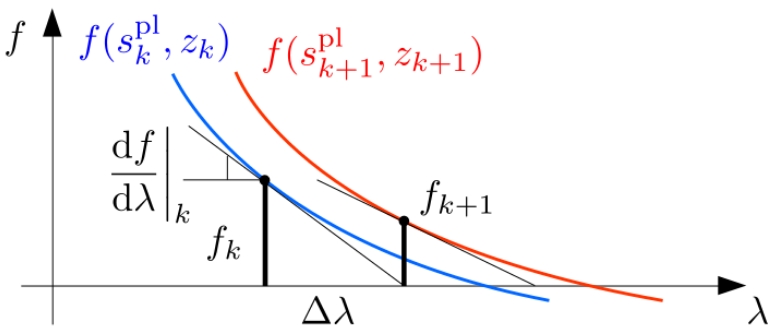
Note that the predictor is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}

Two more questions must addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variables $\boldsymbol{\mathcal{E}}_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

## State update
In every iteration step the state variables $\boldsymbol{\mathcal{E}}$ must be updated using the discrete evolution equations, i.e. 
\begin{align}
\boldsymbol{\mathcal{E}}_{k+1} &= 
\boldsymbol{\mathcal{E}}_k + \lambda_{k+1} 
\boldsymbol{\Phi}_k
\label{eq:discrete_evolution}
\end{align}
Which is used in the calculation of the threshold function in the next step. Note that $\boldsymbol{\Phi}_k$ is evaluated in the state $k$ and not $k+1$.

To reach an admissible state let us linearize the threshold function at an interim state $k$ as
\begin{align}
f_{k+1} = 
f_k 
 +
\left.
\frac
{\partial f}
{\partial \lambda}
\right|_k
\Delta \lambda
\end{align}

## Predictor
\begin{align}
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
&=
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k =
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\boldsymbol{\Phi}_k \\
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
&=
\left. \frac{\partial f}{ \partial \boldsymbol{\mathcal{S}}}\right|_{k}
\left. \frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}\right|_{k}
+
\left. \frac{\partial^{\mathrm{dir}} f}{ \partial^{\mathrm{dir}} \boldsymbol{\mathcal{E}}}\right|_{k}
\label{eq:df_dlambda}
\end{align}

**Remark 1:** The derivative $\partial^\mathrm{dir}$ denotes the direct derivative with respect to $\boldsymbol{\mathcal{E}}$

**Remark 2:** Note that $\displaystyle \frac{\partial \boldsymbol{\mathcal{E}}}{\partial \lambda}$ in equation $\eqref{eq:df_dlambda}$ can be obtained from the evolution equations $\eqref{eq:discrete_evolution}$
\begin{align}
\boldsymbol{\mathcal{E}}_k = \boldsymbol{\mathcal{E}}_n + \lambda \, \boldsymbol{\Phi}_k\; \implies
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k = 
\boldsymbol{\Phi}_k
\end{align}

Thus, by rewriting the linearized equation as a recurrence formula, the iteration algorithm is obtained
\begin{align}
&
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
\Delta \lambda
= - f^{(k)}\\
& \lambda_{k+1} = \lambda_{k} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}_{k+1} = \boldsymbol{\mathcal{E}}_{k} + 
 \lambda_{k} \, 
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
 \\
&k = k + 1
\end{align}

## Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\mathcal{S}(s, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_Sig</td>
<td>get_Sig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}}  \boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}}) $</td>
<td>get_dSig_dEps</td>
<td>get_dSig_dEps_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_df_dSig</td>
<td>get_df_dSig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_df_dEps</td>
<td>get_df_dEps_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} \varphi(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_dphi_dSig</td>
<td>get_dphi_dSig_C</td>
</tr>
</table>

To avoid repeated calculation of the same expressions, let us put the evaluation of $f$ and $\partial_\lambda f$ into a single procedure. The iteration loop can be constructed in such a way that the predictor for the next step is calculated along with the residuum. In case that the residuum is below the required tolerance, the overhead for an extra calculated derivative is negligible or, with some care, can be even reused in the next time step.  

In [47]:
def get_f_df(s_n1, Eps_k, *margs):
    Sig_k = get_Sig(s_n1, Eps_k, *margs)[0]
    dSig_dEps_k = get_dSig_dEps(s_n1, Eps_k, *margs)
    f_k = np.array([get_f(Eps_k, Sig_k, *margs)])
    df_dSig_k = get_df_dSig(Eps_k, Sig_k, *margs)
    ddf_dEps_k = get_ddf_dEps(Eps_k, Sig_k, *margs)
    df_dEps_k = np.einsum(
        'ik,ji->jk', df_dSig_k, dSig_dEps_k) + ddf_dEps_k
    Phi_k = get_Phi(Eps_k, Sig_k, *margs)
    dEps_dlambda_k = Phi_k
    df_dlambda = np.einsum(
        'ki,kj->ij', df_dEps_k, dEps_dlambda_k)
    df_k = df_dlambda
    return f_k, df_k, Sig_k

The update of state variables for an updated $\lambda_\Delta$ is performed using this procedure. This can be still improved. However, as the following sheet will consider all the variables within a common vector of unknowns $\boldsymbol{\sigma}$ and $\lambda_\Delta$ let us keep the evolution update separate also in the algorithm below. 

In [48]:
def get_Eps_k1(s_n1, Eps_n, lam_k, Eps_k, *margs):
    Sig_k = get_Sig(s_n1, Eps_k, *margs)[0]
    Phi_k = get_Phi(Eps_k, Sig_k, *margs)
    Eps_k1 = Eps_n + lam_k * Phi_k[:,0]
    return Eps_k1

The double loop over the time increments and over the return mapping iteration. The inner loop represents the material point level in a standard finite element calculation. The input is the maximum slip value, the number of time steps, the maximum number of iterations and a load function which can define cyclic loading as shown below. The procedure returns the record of $\boldsymbol{\mathcal{E}}(t)$ and $\boldsymbol{\mathcal{S}}(t)$

In [49]:
def get_response(margs, s_max=3, n_steps = 10, k_max=20, get_load_fn=lambda t: t):
    Eps_n = np.zeros((len(Eps),), dtype=np.float_)
    Eps_k = np.copy(Eps_n)
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = np.linspace(0,1,n_steps+1)
    s_t = s_max * get_load_fn(t_arr) + 1e-9
    for s_n1 in s_t:
        lam_k = 0
        f_k, df_k, Sig_k = get_f_df(s_n1, Eps_k, *margs)
        f_k_norm = np.linalg.norm(f_k)
        f_k_trial = f_k[0]
        k = 0
        while k < k_max:
            if f_k_trial < 0 or f_k_norm < 1e-6:
                Eps_n[...] = Eps_k[...]
                Sig_record.append(Sig_k)
                Eps_record.append(np.copy(Eps_k))
                iter_record.append(k+1)
                break
            dlam = np.linalg.solve(df_k, -f_k)
            lam_k += dlam
            Eps_k = get_Eps_k1(s_n1, Eps_n, lam_k, Eps_k, *margs)
            f_k, df_k, Sig_k = get_f_df(s_n1, Eps_k, *margs)
            f_k_norm = np.linalg.norm(f_k)
            k += 1
        else:
            print('no convergence')
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    return t_arr, s_t, Eps_arr, Sig_arr, iter_arr

In [50]:
material_params = {
    E_b:1, gamma:0.2, K:0.1, S:0.005, r:0.001, c:1, tau_bar:1, 
}
material_params = {
    E_b:1, gamma: 0.6, K:1, S:0.6, r:0.001, c:1, tau_bar:1, 
}

In [51]:
margs = [material_params[map_py2sp[name]] for name in py_vars]
margs

In [52]:
t_arr, s_t, Eps_arr, Sigma_arr, iter_arr = get_response(
    margs=margs, s_max=1.1, n_steps=1, k_max=5
)

# Support functions
To run some examples, let us define some infrastructure including a more complex loading history and postprocessing

## Loading history
This implementation uses the symbolic machinery which is not necessary a simpler data point based implementation with `numpy.interp1d` would be better ... later 

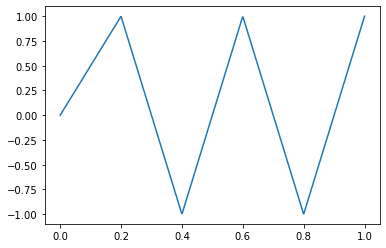

In [53]:
t, theta = sp.symbols(r't, \theta')
n_cycles = 5
A = 2
ups = np.array([((theta-2*cycle)*A+(1-A), theta-2*cycle<=1) 
                for cycle in range(n_cycles)])
downs = np.array([((1-(theta-(2*cycle+1)))*A+(1-A),(theta-(2*cycle+1))<=1) 
                  for cycle in range(n_cycles)])
ups[0,0] = theta
updowns = np.einsum('ijk->jik',np.array([ups, downs])).reshape(-1,2)
load_fn = sp.Piecewise(*updowns).subs(theta,t*n_cycles)
get_load_fn = sp.lambdify(t, load_fn,'numpy')
t_arr = np.linspace(0,1,600)
plt.plot(t_arr, get_load_fn(t_arr));

## Plotting functions
To simplify postprocessing examples, here are two aggregate plotting functions, one for the state and force variables, the other one for the evaluation of energies

In [54]:
def plot_Sig_Eps(Sig_arr, Eps_arr, ax1, ax2, ax3, ax4):
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    s_pi_, z_, alpha_, omega_ = Eps_arr.T
    sig_pi_, Z_, X_, Y_ = Sig_arr.T
    n_step = len(s_pi_)
    ax1.plot(s_t, sig_pi_, color='black', 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11 = ax1.twinx()
    ax11.plot(s_t, iter_arr, '-.')
    ax2.plot(t_arr, omega_, color='red', 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22 = ax2.twinx()
    ax22.plot(t_arr, Y_, '-.', color='red', 
             label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(t_arr, z_, color='green', 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
    ax33 = ax3.twinx()
    ax33.plot(t_arr, Z_, '-.', color='green')
    ax33.set_ylabel(r'$Z$')
    ax4.plot(t_arr, alpha_, color='blue', 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')
    ax44 = ax4.twinx()
    ax44.plot(t_arr, X_, '-.', color='blue')

In [55]:
from scipy.integrate import cumtrapz
def plot_work(ax, Eps_arr, Sig_arr):
    W_arr = cumtrapz(Sig_arr[:,0], s_t, initial=0)
    U_arr = Sig_arr[:,0] * (s_t-Eps_arr[:,0]) / 2.0
    G_arr = W_arr - U_arr
    ax.plot(t_arr, W_arr, lw=2, color='black', label=r'$W$')
    ax.plot(t_arr, G_arr, color='black', label=r'$G$')
    ax.fill_between(t_arr, W_arr, G_arr, color='green', alpha=0.2)
    ax.set_xlabel('$s$'); ax3.set_ylabel(r'$E$')
    ax.legend()

In [56]:
def plot_dissipation(ax, Eps_arr, Sig_arr):    
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    E_i = cumtrapz(Sig_arr, Eps_arr, initial=0, axis=0)
    c = 'black'
    ax.plot(t_arr, E_i[:,0], '-.', lw=1, color=c)
    ax.fill_between(t_arr, E_i[:,0], 0, color=c, alpha=0.1)
    c = 'black'
    ax.plot(t_arr, E_i[:,0] + E_i[:,3], color=c, lw=1)
    ax.fill_between(t_arr, E_i[:,0] + E_i[:,3], E_i[:,0], 
                    color=c, alpha=0.2);
    c = 'blue'
    ax.plot(t_arr, E_i[:,1], '-.', lw=1, color='black')
    ax.fill_between(t_arr, E_i[:,1], 0, color=c, alpha=0.1)
    c = 'blue'
    ax.plot(t_arr, E_i[:,1] + E_i[:,2], color='black', lw=1)
    ax.fill_between(t_arr, E_i[:,1] + E_i[:,2], E_i[:,1], 
                    color=c, alpha=0.3);

# Examples

## Monotonic load 
Let's first run the example with different size of the time step to see if there is any difference

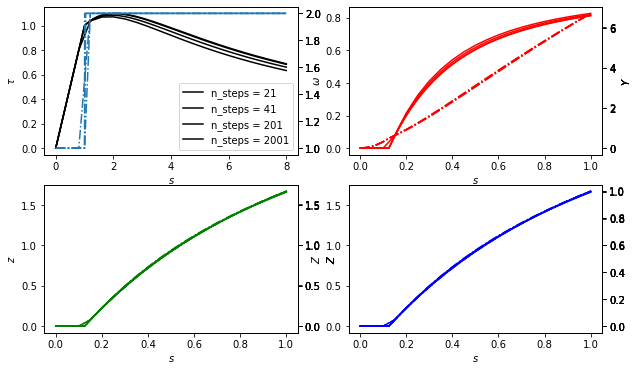

In [57]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
for n_steps in [20, 40, 200, 2000]:
    t_arr, s_t, Eps_arr, Sig_arr, iter_arr = get_response(
        margs=margs, s_max=8, n_steps=n_steps, k_max=10
    )
    plot_Sig_Eps(Sig_arr, Eps_arr, ax1, ax2, ax3, ax4)

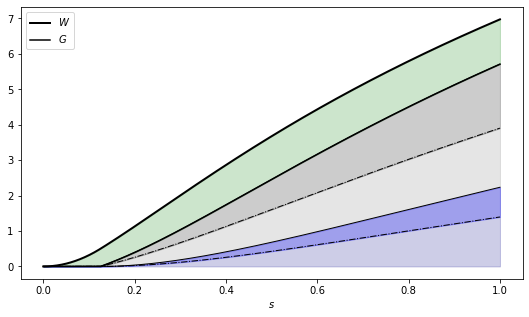

In [58]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, Eps_arr, Sig_arr)
plot_dissipation(ax, Eps_arr, Sig_arr)

## Cyclic loading

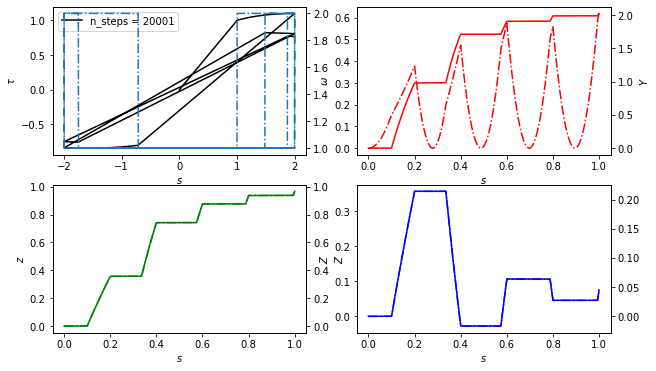

In [59]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
t_arr, s_t, Eps_arr, Sig_arr, iter_arr = get_response(
    margs, s_max=2, n_steps=20000, k_max=20, get_load_fn=get_load_fn
)
plot_Sig_Eps(Sig_arr, Eps_arr, ax1, ax2, ax3, ax4)

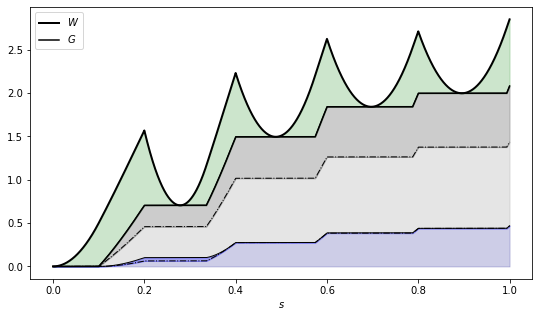

In [60]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, Eps_arr, Sig_arr)
plot_dissipation(ax, Eps_arr, Sig_arr)

# Code generation
See the docs for the code generation, the latexified  sympy symbols 
must be substituted such that they can act as standard C variable names.
The methods `get_f_df()` and `get_Eps_n1` must be paraphrased in C.
The state arrays `Eps` and `Sig` must be prepared by the callee.
All the matrices are flattened in C code so that index access operators 
must be constructed with the correct convention, i.e. 
`i * n_row + j` or `i + n_col * j`. 

The whole material model is represented by the material method
that mimics the internal par of the `get_response` function defined above

 1. Call `get_f_df()` to get the trial state
 2. Start the return mapping iteration loop
 3. If admissibility criterion fulfilled - admissible state found - return stress
 4. Evaluate delta of plastic multiplier and update it
 5. Update state variables using evolution equations `get_Eps_n1`
 6. Evaluate the residuum using `get_f_df()` and continuum with point 3.
 

In [76]:
print(get_f_C[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

double f(double X, double Z, double bartau, double omega, double tau_pi) {

   double f_result;
   f_result = -Z - bartau + sqrt(pow(-X + tau_pi/(1 - omega), 2));
   return f_result;

}



In [77]:
print(get_dSig_dEps_C[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

void dSig_dEps(double E_b, double K, double gamma, double omega, double s, double s_pi, double *out_6209896088754829193) {

   out_6209896088754829193[0] = -E_b*(1 - omega);
   out_6209896088754829193[1] = 0;
   out_6209896088754829193[2] = 0;
   out_6209896088754829193[3] = (1.0/2.0)*E_b*(-2*s + 2*s_pi);
   out_6209896088754829193[4] = 0;
   out_6209896088754829193[5] = K;
   out_62098960887548

In [75]:
print(get_f_C[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

double f(double X, double Z, double bartau, double omega, double tau_pi) {

   double f_result;
   f_result = -Z - bartau + sqrt(pow(-X + tau_pi/(1 - omega), 2));
   return f_result;

}



In [73]:
print(get_df_dSig_C[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

void df_dSig(double X, double omega, double tau_pi, double *out_5150037501156110656) {

   out_5150037501156110656[0] = sqrt(pow(-X + tau_pi/(1 - omega), 2))/((1 - omega)*(-X + tau_pi/(1 - omega)));
   out_5150037501156110656[1] = -1;
   out_5150037501156110656[2] = (X - tau_pi/(1 - omega))*sqrt(pow(-X + tau_pi/(1 - omega), 2))/pow(-X + tau_pi/(1 - omega), 2);
   out_5150037501156110656[3] = 0;
